# Preparation

In [1]:
import os
os.chdir("/home/jovyan/work")
!pip install tqdm

You are using pip version 9.0.3, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Control Task 3.2
Provide the given plots of a Beta Distribution

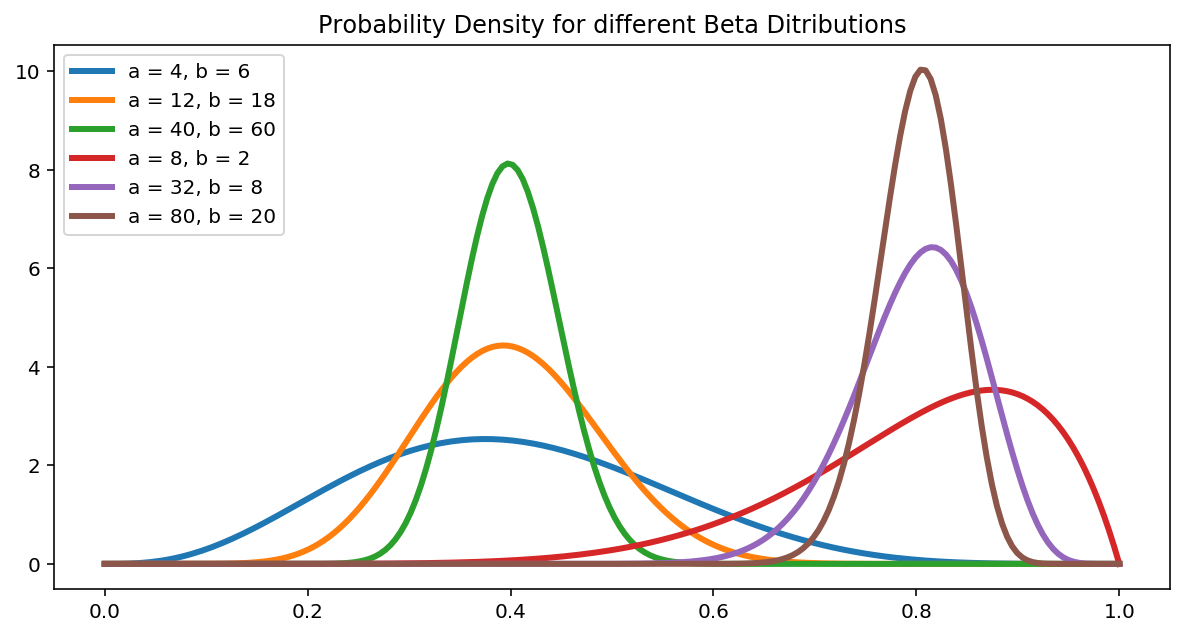

In [2]:
# %load src/3-02-beta-pdfs.py
# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

# Prepare Distributions
alphas = [4, 12, 40, 8, 32, 80]
betas = [6, 18, 60, 2, 8, 20]

# Sample
x = np.linspace(0, 1, 200)

for a, b in zip(alphas, betas):
    plt.plot(
        x, 
        beta(a, b).pdf(x), 
        linewidth=3,
        label="a = {}, b = {}".format(a ,b)
    )
plt.legend(loc=0)
plt.title("Probability Density for different Beta Ditributions")
plt.savefig("./results/3-02-beta-pdfs.png")

# Control Task 3.5

In [3]:
# %load src/3-00-mcmc.py
import numpy as np
from scipy.stats import norm
from tqdm import tqdm

def mcmc(data, dist, target, init, proposal_width, params_prior, params_const, n_iter, desc=None):
    """MCMC Metropolis Sampling
    
    Parameter
    ---------
    data: 1-d array,
        observerd data
    dist: scipy.stats distribution,
        distribution that underlies the sampling
    target: str,
        target param to be sampled
    init: float,
        initial value for the target parameter
    proposal_width: float,
        step-width of sampling
    params_prior: dict,
        priors of the distribution
    params_const: dict,
        constant parameter of the distribution,
    n_iter: int,
        number of samplings
        
    Return
    ------
    trace: 1-d array,
        trace of the sampling
    """
    params_current = params_const.copy() # defensive copy (!)
    params_current.update({target: init})
    params_proposal = params_const.copy() # defensive copy (!)
    trace = [params_current[target]]
    for _ in tqdm(range(n_iter), desc=desc):

        # proposal
        proposal = norm(params_current[target], proposal_width).rvs()
        params_proposal.update({target: proposal})
        
        # likelihoods
        l_current = dist(**params_current).pdf(data).prod()
        l_proposal = dist(**params_proposal).pdf(data).prod()
        
        # priors
        pr_current = dist(**params_prior).pdf(params_current[target])
        pr_proposal = dist(**params_prior).pdf(params_proposal[target])
        
        # probabilities
        p_current = l_current * pr_current
        p_proposal = l_proposal * pr_proposal
        
        # switch (?)
        accept = np.random.rand() < (p_proposal / p_current)
        
        if accept:
            params_current = params_proposal.copy() # defensive copy (!)
        trace.append(params_current[target])
    return trace

Step Size - 100: 100%|██████████| 10000/10000 [01:35<00:00, 104.52it/s]


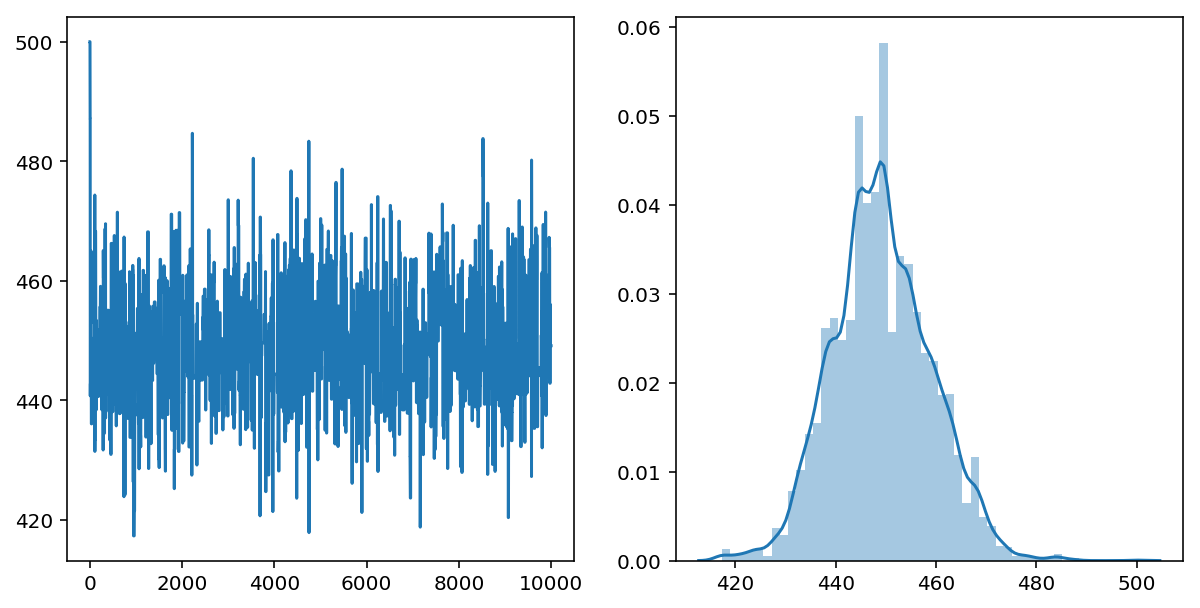

In [4]:
# %load src/3-05-mcmc-sampling.py
# Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

# Generate data
data = norm(450, 50).rvs(25)

# Sample
trace = mcmc(
    data=data, 
    dist=norm, 
    target="loc", 
    init=500, 
    proposal_width=100, 
    params_prior={"loc": 500, "scale": 70},
    params_const={"scale": 50},
    n_iter=10000,
    desc="Step Size - 100"
)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(range(len(trace)), trace)
sns.distplot(trace, ax=ax[1])
plt.savefig("./results/3-05-mcmc-results.png")

Step Size - 200: 100%|██████████| 10000/10000 [00:45<00:00, 221.49it/s]


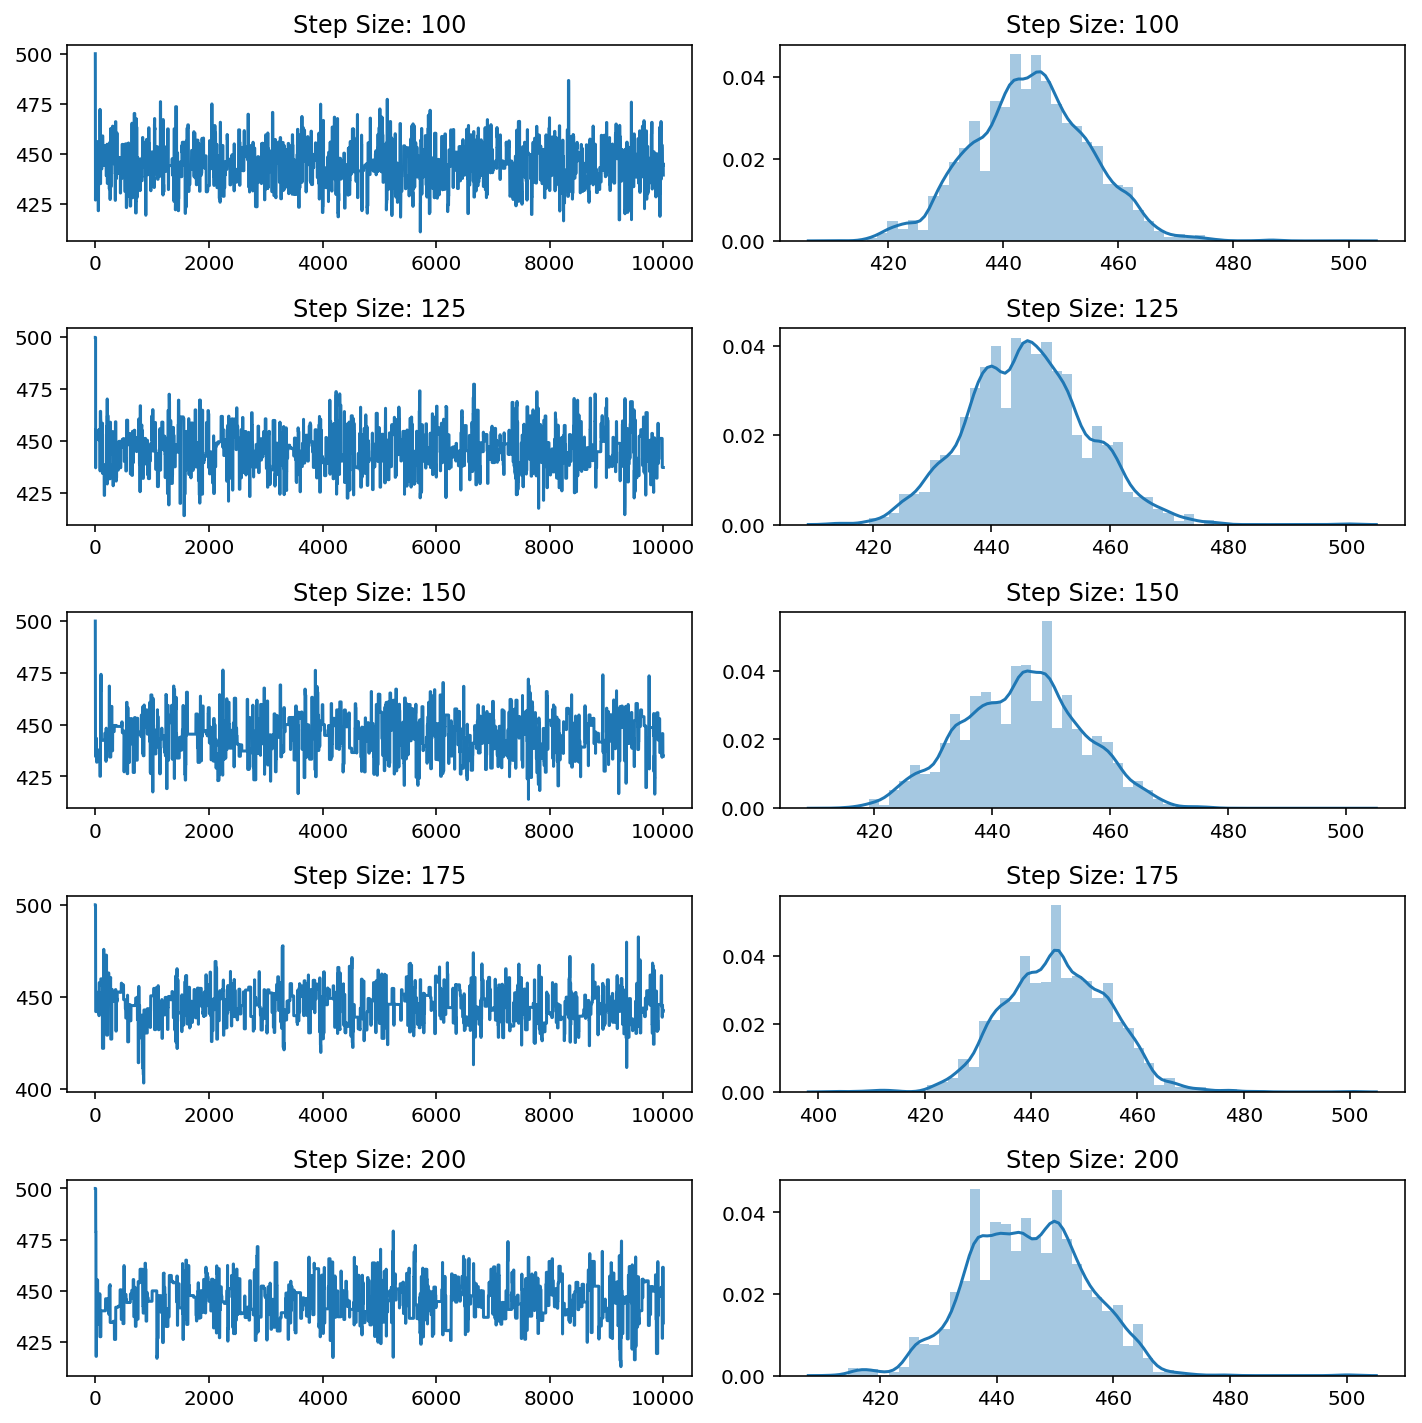

In [5]:
# %load src/3-06-sampling-sizes.py
# Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Config
os.chdir("/home/jovyan/work")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

# Generate data
data = norm(450, 50).rvs(25)

step_sizes = [100, 125, 150, 175, 200]
traces = []

# Sample
for step_size in step_sizes:
    
    traces.append(mcmc(
        data=data, 
        dist=norm, 
        target="loc", 
        init=500, 
        proposal_width=step_size, 
        params_prior={"loc": 500, "scale": 70},
        params_const={"scale": 50},
        n_iter=10000,
        desc="Step Size - {}".format(step_size)
    ))

# Plot
fig, ax = plt.subplots(nrows=len(step_sizes), ncols=2)
for idx, step in enumerate(step_sizes):
    ax[idx][0].plot(range(len(traces[idx])), traces[idx])
    ax[idx][0].set_title("Step Size: {}".format(step))
    sns.distplot(traces[idx], ax=ax[idx][1])
    ax[idx][1].set_title("Step Size: {}".format(step))
plt.tight_layout()
plt.savefig("./results/3-06-mcmc-step-sizes.png")